# Data Preparation for YOLO Instance Segmentation

This notebook prepares the food-recognition-2022 dataset for training a YOLOv11n-seg model. We will:
1. Load and parse the annotations from the JSON files
2. Create the YOLO directory structure
3. Convert instance segmentation masks to YOLO format
4. Create a dataset.yaml file for training

In [1]:
# Import required libraries
import os
import json
import shutil
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Setup Paths

In [3]:
# Define dataset paths
DATA_ROOT = Path("/home/kuba/Coding/Uczelnia/fridge_project/datasets/food-recognition-2022")
TRAIN_DIR = DATA_ROOT / "training"
VAL_DIR = DATA_ROOT / "val"
TEST_DIR = DATA_ROOT / "test" / "images"

# Create YOLO dataset directory
YOLO_DATASET_DIR = Path("/home/kuba/Coding/Uczelnia/fridge_project/datasets/yolo_food_dataset")
os.makedirs(YOLO_DATASET_DIR, exist_ok=True)

# Define YOLO directory structure
for split in ["train", "val"]:
    os.makedirs(YOLO_DATASET_DIR / split / "images", exist_ok=True)
    os.makedirs(YOLO_DATASET_DIR / split / "labels", exist_ok=True)

# Verify paths
print(f"Training directory: {TRAIN_DIR}")
print(f"Validation directory: {VAL_DIR}")
print(f"YOLO dataset directory: {YOLO_DATASET_DIR}")

Training directory: /home/kuba/Coding/Uczelnia/fridge_project/datasets/food-recognition-2022/training
Validation directory: /home/kuba/Coding/Uczelnia/fridge_project/datasets/food-recognition-2022/val
YOLO dataset directory: /home/kuba/Coding/Uczelnia/fridge_project/datasets/yolo_food_dataset


## Load Annotations

In [4]:
# Load annotations from JSON files
def load_annotations(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

# Load train and validation annotations
train_annotations = load_annotations(TRAIN_DIR / "annotations.json")
val_annotations = load_annotations(VAL_DIR / "annotations.json")

# Extract class information and create a class mapping
categories = {cat['id']: cat['name'] for cat in train_annotations['categories']}
class_ids = {cat_id: idx for idx, cat_id in enumerate(categories.keys())}

print(f"Found {len(categories)} categories:")
for cat_id, name in categories.items():
    print(f"  {class_ids[cat_id]}: {name} (original id: {cat_id})")

print(f"\nTraining images: {len(train_annotations['images'])}")
print(f"Validation images: {len(val_annotations['images'])}")
print(f"Training annotations: {len(train_annotations['annotations'])}")
print(f"Validation annotations: {len(val_annotations['annotations'])}")

Found 498 categories:
  0: bread-wholemeal (original id: 1565)
  1: jam (original id: 2099)
  2: water (original id: 2578)
  3: bread-sourdough (original id: 1556)
  4: banana (original id: 1154)
  5: soft-cheese (original id: 1352)
  6: ham-raw (original id: 1893)
  7: hard-cheese (original id: 1310)
  8: cottage-cheese (original id: 1264)
  9: bread-half-white (original id: 1536)
  10: coffee-with-caffeine (original id: 2512)
  11: fruit-salad (original id: 1166)
  12: pancakes (original id: 2949)
  13: tea (original id: 2498)
  14: salmon-smoked (original id: 2973)
  15: avocado (original id: 1056)
  16: spring-onion-scallion (original id: 1111)
  17: ristretto-with-caffeine (original id: 2524)
  18: ham (original id: 1886)
  19: egg (original id: 2022)
  20: bacon-frying (original id: 1915)
  21: chips-french-fries (original id: 1013)
  22: juice-apple (original id: 2446)
  23: chicken (original id: 1788)
  24: tomato-raw (original id: 1069)
  25: broccoli (original id: 1085)
  26:

## Process Annotations

Convert the COCO format annotations to YOLO format:
- YOLO expects one text file per image in the "labels" directory
- Each line in the text file represents one object: `class_id x_center y_center width height x1 y1 x2 y2 ... xn yn`
- The first 5 values are the class ID and normalized bounding box coordinates (center_x, center_y, width, height)
- The remaining values are normalized polygon points of the segmentation mask (x1, y1, x2, y2, ...)

In [6]:
def process_dataset(annotations, src_dir, dest_images_dir, dest_labels_dir):
    # Create image_id to filename mapping
    image_dict = {img['id']: img for img in annotations['images']}
    
    # Group annotations by image_id
    image_annotations = {}
    for ann in annotations['annotations']:
        image_id = ann['image_id']
        if image_id not in image_annotations:
            image_annotations[image_id] = []
        image_annotations[image_id].append(ann)
    
    # Process each image
    for image_id, anns in tqdm(image_annotations.items(), desc="Processing images"):
        image_info = image_dict[image_id]
        filename = image_info['file_name']
        
        # Get image dimensions
        img_width = image_info['width']
        img_height = image_info['height']
        
        # Copy image to destination
        src_path = src_dir / filename
        dest_path = dest_images_dir / filename
        shutil.copy(src_path, dest_path)
        
        # Create YOLO annotation file
        label_lines = []
        
        for ann in anns:
            category_id = ann['category_id']
            yolo_class_id = class_ids[category_id]
            
            # Convert bbox to YOLO format (normalized x_center, y_center, width, height)
            x, y, w, h = ann['bbox']
            x_center = (x + w/2) / img_width
            y_center = (y + h/2) / img_height
            width = w / img_width
            height = h / img_height
            
            # Convert segmentation polygon to YOLO format (normalized coordinates)
            if isinstance(ann['segmentation'], list) and len(ann['segmentation']) > 0:
                polygon = ann['segmentation'][0]  # Take the first polygon if there are multiple
                points = []
                for i in range(0, len(polygon), 2):
                    x_coord = polygon[i] / img_width
                    y_coord = polygon[i+1] / img_height
                    points.extend([x_coord, y_coord])
                
                # Create YOLO format line
                line = f"{yolo_class_id} {x_center} {y_center} {width} {height}"
                for p in points:
                    line += f" {p}"
                label_lines.append(line)
        
        # Write label file
        if label_lines:
            label_filename = os.path.splitext(filename)[0] + '.txt'
            with open(dest_labels_dir / label_filename, 'w') as f:
                f.write('\n'.join(label_lines))

# Process training and validation datasets
print("Processing training dataset...")
process_dataset(train_annotations, TRAIN_DIR / "images", 
                YOLO_DATASET_DIR / "train" / "images", 
                YOLO_DATASET_DIR / "train" / "labels")

print("Processing validation dataset...")
process_dataset(val_annotations, VAL_DIR / "images", 
                YOLO_DATASET_DIR / "val" / "images", 
                YOLO_DATASET_DIR / "val" / "labels")

Processing training dataset...


Processing images:   0%|          | 0/39962 [00:00<?, ?it/s]

Processing validation dataset...


Processing images:   0%|          | 0/1000 [00:00<?, ?it/s]

## Create Dataset Configuration

In [7]:
# Create dataset.yaml for YOLO training
yaml_content = f"""# YOLO Food Recognition Dataset
path: {YOLO_DATASET_DIR}
train: train/images
val: val/images

# Classes
names:
"""

for cat_id, name in sorted([(class_ids[k], v) for k, v in categories.items()]):
    yaml_content += f"  {cat_id}: '{name}'\n"

# Write YAML file
yaml_path = YOLO_DATASET_DIR / "dataset.yaml"
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"Dataset configuration saved to {yaml_path}")
print("Sample of the YAML file:")
print("\n".join(yaml_content.split("\n")[:10]) + "\n...")

Dataset configuration saved to /home/kuba/Coding/Uczelnia/fridge_project/datasets/yolo_food_dataset/dataset.yaml
Sample of the YAML file:
# YOLO Food Recognition Dataset
path: /home/kuba/Coding/Uczelnia/fridge_project/datasets/yolo_food_dataset
train: train/images
val: val/images

# Classes
names:
  0: 'bread-wholemeal'
  1: 'jam'
  2: 'water'
...


## Verify Dataset

In [8]:
# Count files in dataset directories
train_images = len(list((YOLO_DATASET_DIR / "train" / "images").glob("*")))
train_labels = len(list((YOLO_DATASET_DIR / "train" / "labels").glob("*.txt")))
val_images = len(list((YOLO_DATASET_DIR / "val" / "images").glob("*")))
val_labels = len(list((YOLO_DATASET_DIR / "val" / "labels").glob("*.txt")))

print(f"Train images: {train_images}")
print(f"Train labels: {train_labels}")
print(f"Validation images: {val_images}")
print(f"Validation labels: {val_labels}")

# Sample a few labels to verify
def sample_label(labels_dir, n=3):
    label_files = list(labels_dir.glob("*.txt"))
    if not label_files:
        return "No label files found"
    
    samples = []
    for i in range(min(n, len(label_files))):
        with open(label_files[i], 'r') as f:
            content = f.read().strip()
            samples.append(f"File: {label_files[i].name}\n{content[:300]}{'...' if len(content) > 300 else ''}")
    return "\n\n".join(samples)

print("\nSample training labels:")
print(sample_label(YOLO_DATASET_DIR / "train" / "labels"))

Train images: 39962
Train labels: 39962
Validation images: 1000
Validation labels: 1000

Sample training labels:
File: 131094.txt
5 0.25625 0.178125 0.34791666666666665 0.19166666666666668 0.23958333333333334 0.43020833333333336 0.20416666666666666 0.42604166666666665 0.15520833333333334 0.37916666666666665 0.13541666666666666 0.3489583333333333 0.09895833333333333 0.325 0.08229166666666667 0.28541666666666665 0.08229166666666...

File: 131097.txt
11 0.5118606138107417 0.44363461538461535 0.7962212276214834 0.6591858974358974 0.40875 0.8847339743589743 0.36625 0.9123044871794871 0.23125 0.8646826923076922 0.15875 0.8471378205128204 0.11375 0.7919967948717948 0.14125 0.7168044871794871 0.25625 0.7318429487179486 0.33375 0.7468814102564103 0.34...

File: 131098.txt
12 0.47686061381074163 0.478724358974359 0.6562212276214834 0.6591858974358975 0.58625 0.7894903846153845 0.48375 0.8070352564102563 0.37875000000000003 0.804528846153846 0.25125 0.7293365384615383 0.18625 0.6466249999999999 0

## Visualize Sample Annotations

Let's visualize some images with their annotations to verify the conversion was successful.

Visualizing training samples:


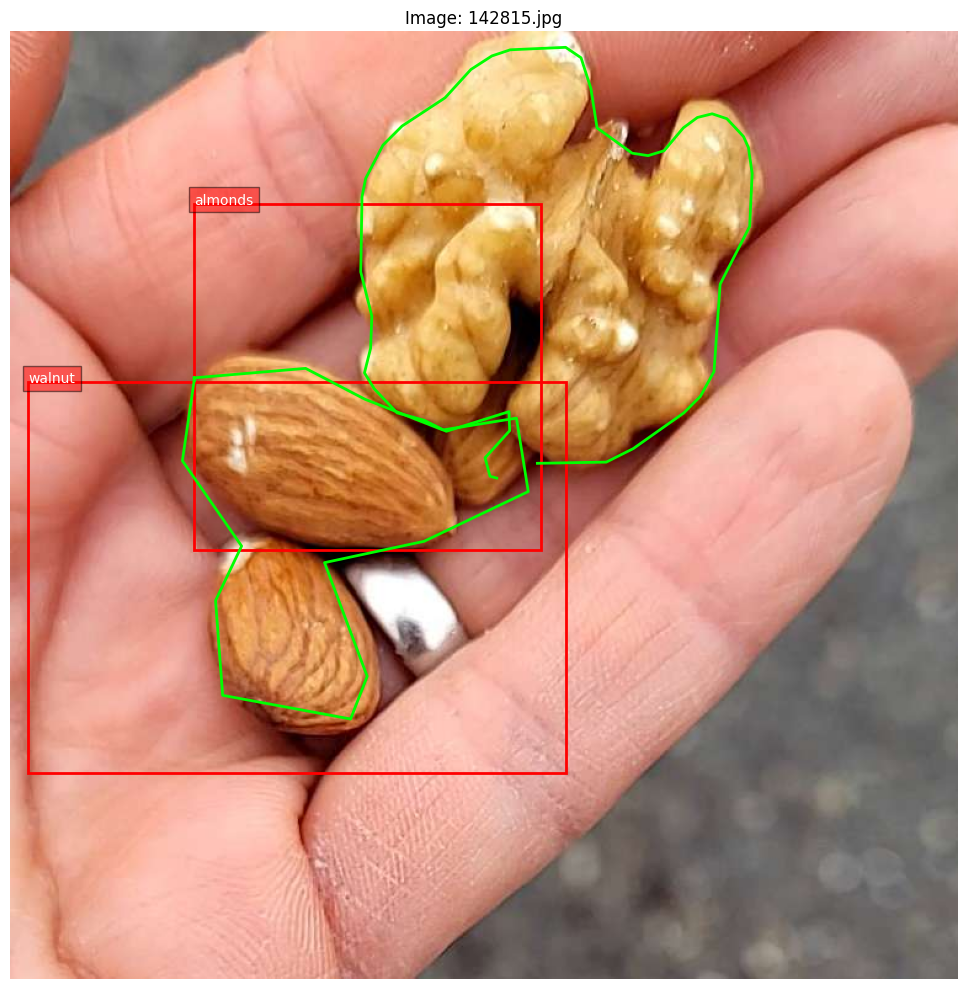

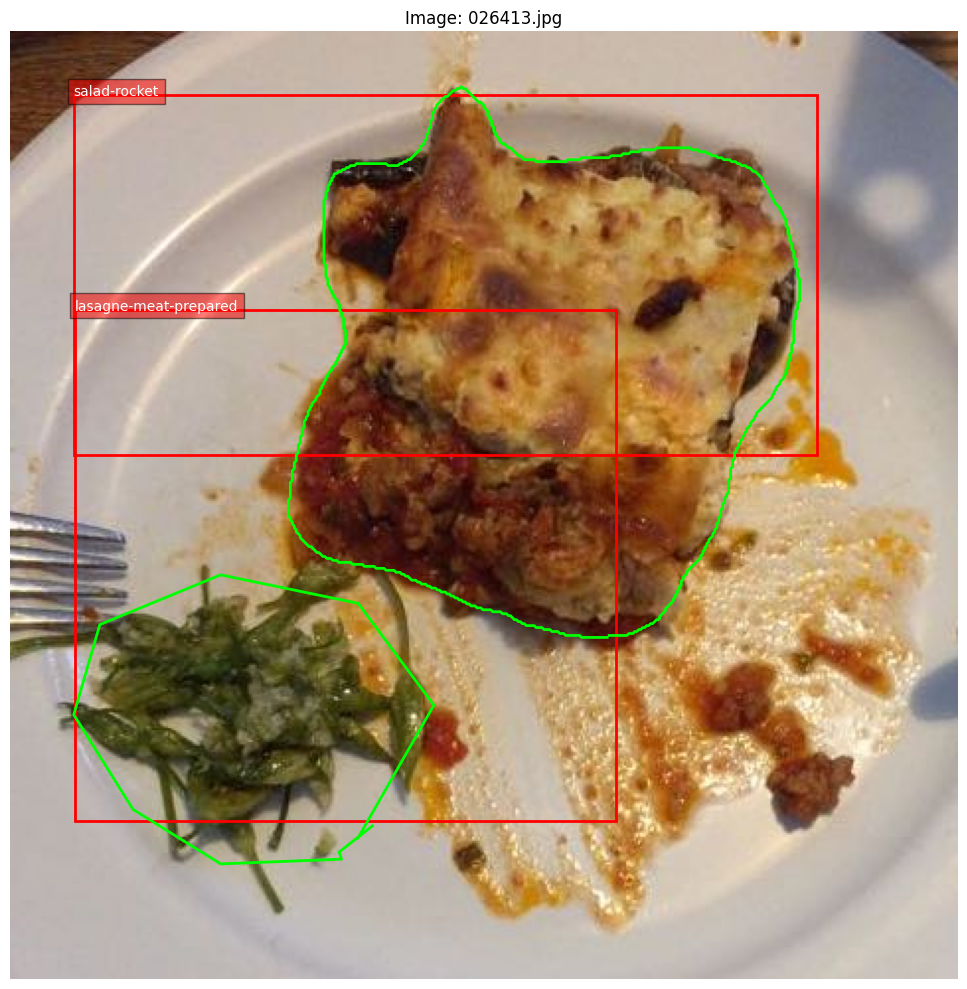

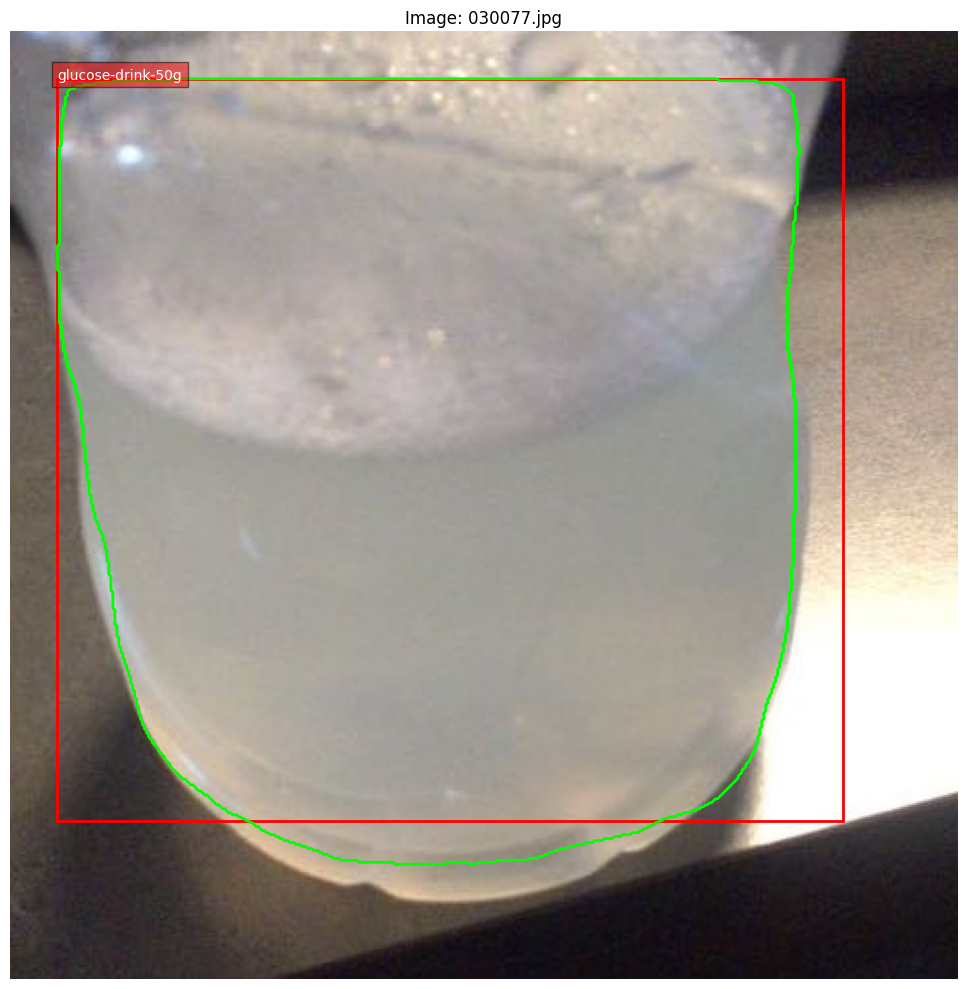

Visualizing validation samples:


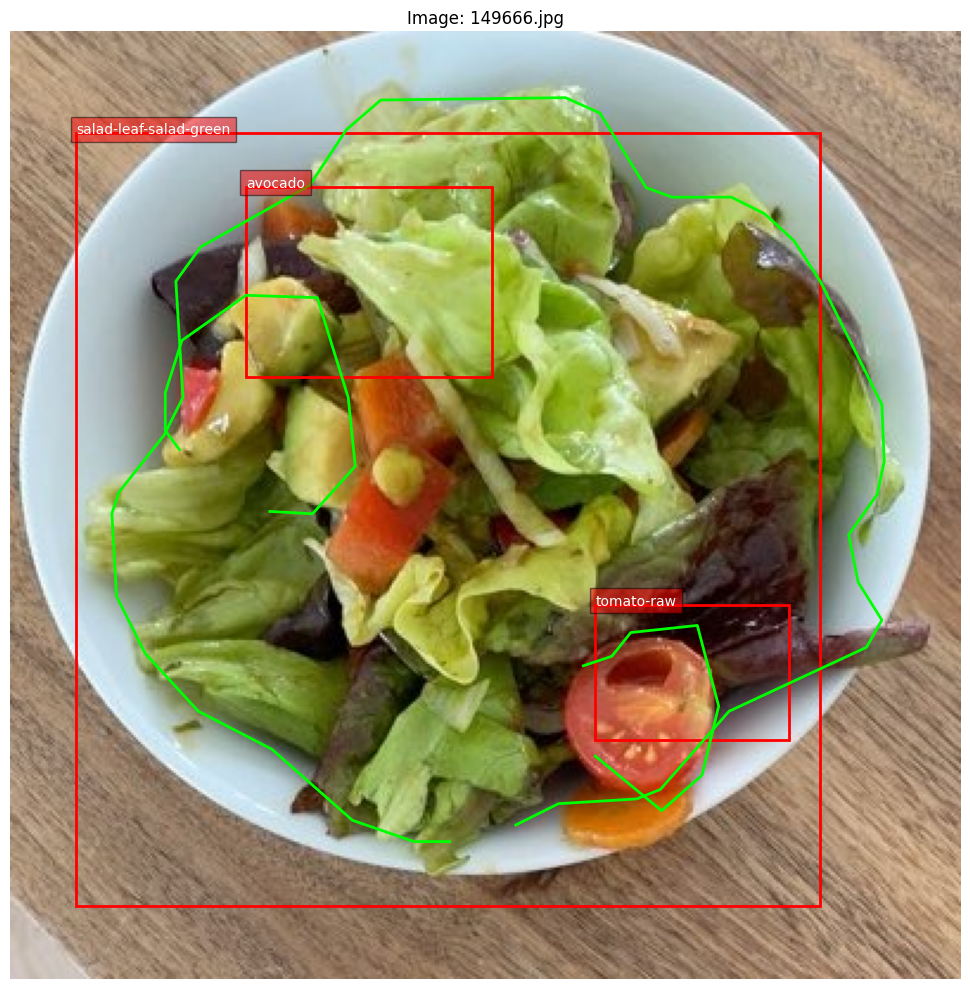

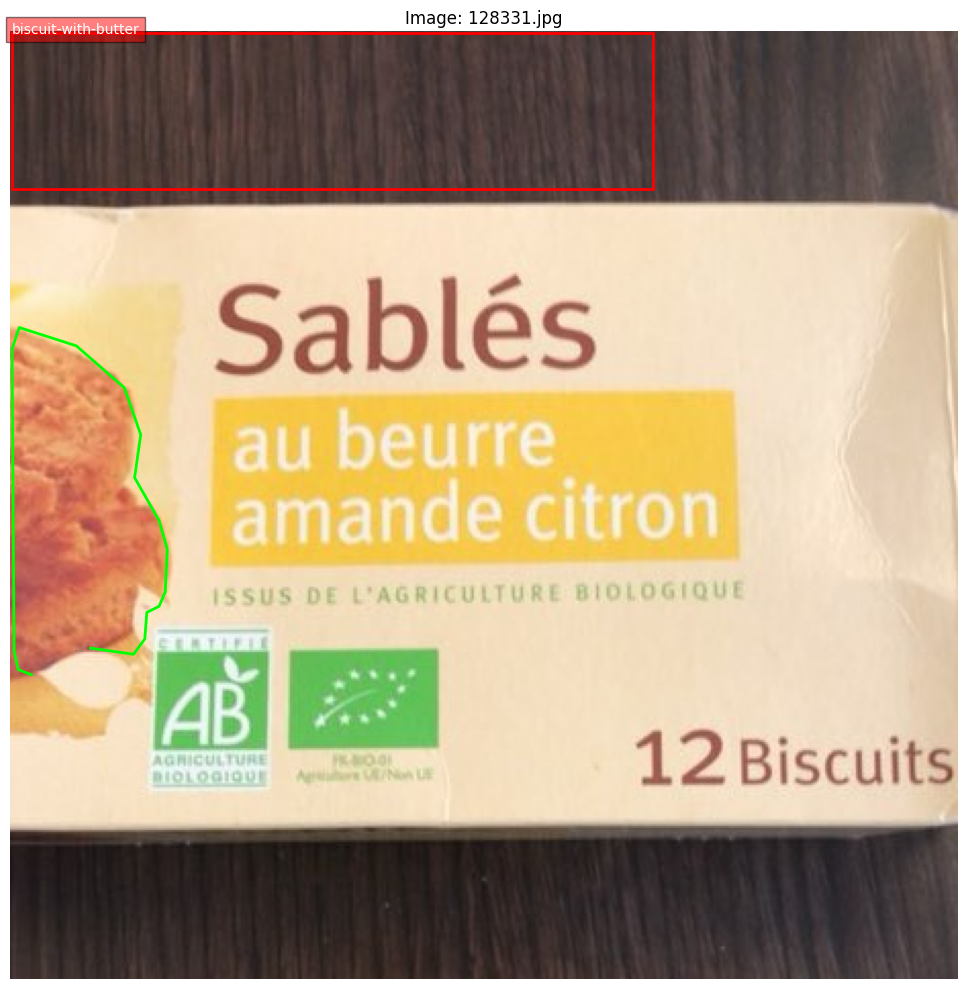

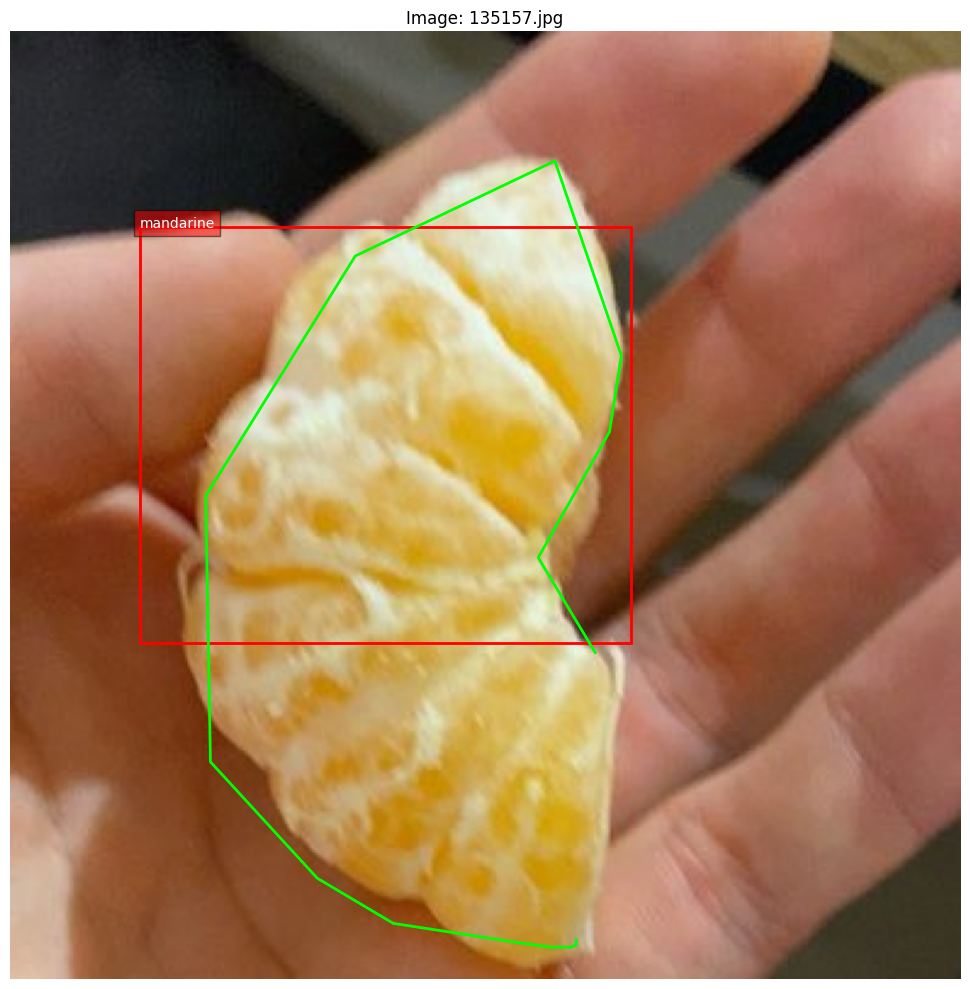

In [10]:
def draw_yolo_annotations(image_path, label_path):
    # Load image
    img = Image.open(image_path)
    img_width, img_height = img.size
    
    # Create figure
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)
    
    # Load labels
    if not os.path.exists(label_path):
        ax.set_title(f"Image: {os.path.basename(image_path)}\nNo annotations found")
        return fig
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # Draw each annotation
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        class_name = next((v for k, v in categories.items() if class_ids[k] == class_id), f"Class {class_id}")
        
        # Bounding box (normalized xywh -> pixel xyxy)
        x_center, y_center, width, height = map(float, parts[1:5])
        x_min = (x_center - width/2) * img_width
        y_min = (y_center - height/2) * img_height
        box_width = width * img_width
        box_height = height * img_height
        
        # Draw rectangle
        rect = plt.Rectangle((x_min, y_min), box_width, box_height,
                            fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x_min, y_min, class_name, color='white',
                bbox=dict(facecolor='red', alpha=0.5))
        
        # Draw segmentation polygon if available
        if len(parts) > 5:
            poly_points = parts[5:]
            polygon = []
            for i in range(0, len(poly_points), 2):
                x = float(poly_points[i]) * img_width
                y = float(poly_points[i+1]) * img_height
                polygon.append((x, y))
            
            poly_xs, poly_ys = zip(*polygon)
            ax.plot(poly_xs, poly_ys, '-', color='lime', linewidth=2)
    
    ax.set_title(f"Image: {os.path.basename(image_path)}")
    ax.axis('off')
    return fig

# Visualize a few random examples
def visualize_random_samples(split="train", n=3):
    images_dir = YOLO_DATASET_DIR / split / "images"
    labels_dir = YOLO_DATASET_DIR / split / "labels"
    
    image_files = list(images_dir.glob("*"))
    if not image_files:
        print(f"No images found in {images_dir}")
        return
    
    # Sample n random images
    import random
    sample_images = random.sample(image_files, min(n, len(image_files)))
    
    for img_path in sample_images:
        base_name = os.path.splitext(img_path.name)[0]
        label_path = labels_dir / f"{base_name}.txt"
        fig = draw_yolo_annotations(img_path, label_path)
        plt.tight_layout()
        plt.show()

print("Visualizing training samples:")
visualize_random_samples("train", 3)

print("Visualizing validation samples:")
visualize_random_samples("val", 3)

## Prepare for Training

Now that the dataset is prepared in YOLO format, you can train your model using YOLOv11n-seg.
Here's a sample command you might use for training:

In [ ]:
print("""
# Example command to train YOLOv11n-seg model on your dataset
# Make sure to install the appropriate version of Ultralytics first:
# pip install ultralytics

from ultralytics import YOLO

# Load a pretrained YOLOv11n-seg model
model = YOLO('yolov11n-seg.pt')

# Train the model
results = model.train(
    data=f'{YOLO_DATASET_DIR}/dataset.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    name='food_recognition_model'
)
""")

## Conclusion

This notebook has:
1. Converted the food recognition dataset from COCO format to YOLO format
2. Created the proper directory structure for training
3. Generated a dataset.yaml file with class information
4. Verified the conversion with visualizations

Your dataset is now ready for training with YOLOv11n-seg. You can use the training code provided above to start training your model.